In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

KeyboardInterrupt: 

 PROJECT TITLE -  Shopper Spectrum: Customer Segmentation and Product Recommendations in E-Commerce

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
import warnings
warnings.filterwarnings('ignore')


In [5]:
df = pd.read_csv('D:\VIT\ecommerce_rfm_recommender\data\online_retail.csv', encoding='ISO-8859-1')
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2022-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2022-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom


In [6]:
df.dropna(subset=['CustomerID'], inplace=True)


In [7]:
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]


In [8]:
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]


In [9]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']


In [10]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


In [11]:
df = df.drop_duplicates()


In [12]:
df.reset_index(drop=True, inplace=True)
df.shape


(392692, 9)

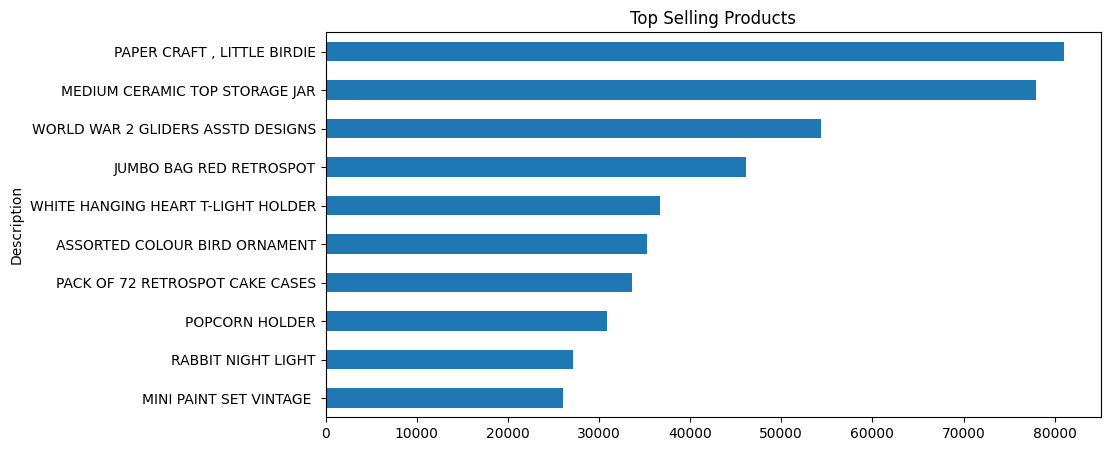

In [13]:
top_products = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
top_products.plot(kind='barh', title='Top Selling Products', figsize=(10, 5))
plt.gca().invert_yaxis()
plt.show()


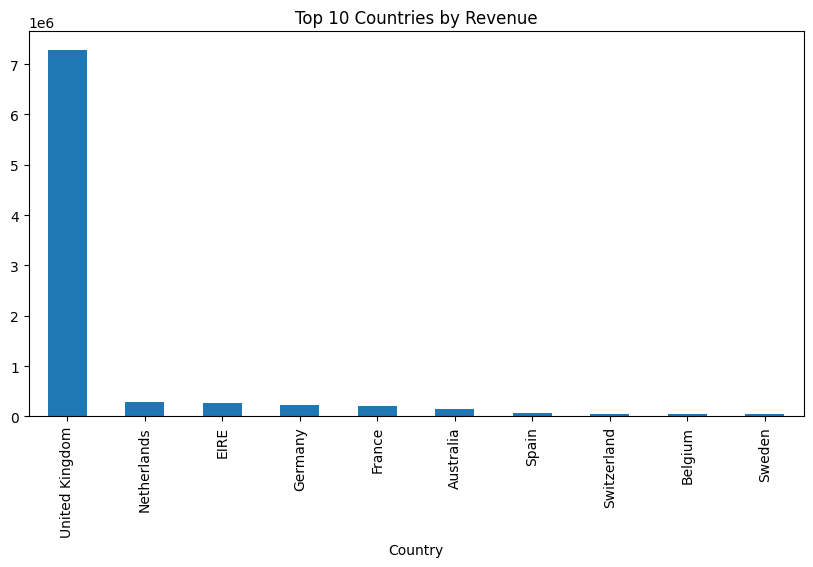

In [14]:
country_sales = df.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False).head(10)
country_sales.plot(kind='bar', title='Top 10 Countries by Revenue', figsize=(10, 5))
plt.show()


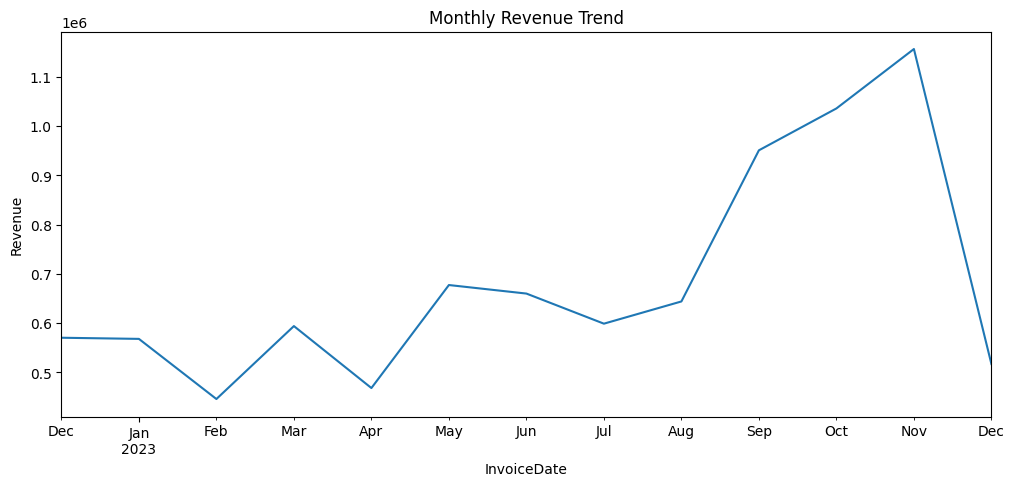

In [15]:
df.set_index('InvoiceDate').resample('M')['TotalPrice'].sum().plot(title='Monthly Revenue Trend', figsize=(12, 5))
plt.ylabel('Revenue')
plt.show()


In [16]:
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)


In [17]:
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()

In [18]:
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


In [19]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])


In [20]:
inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

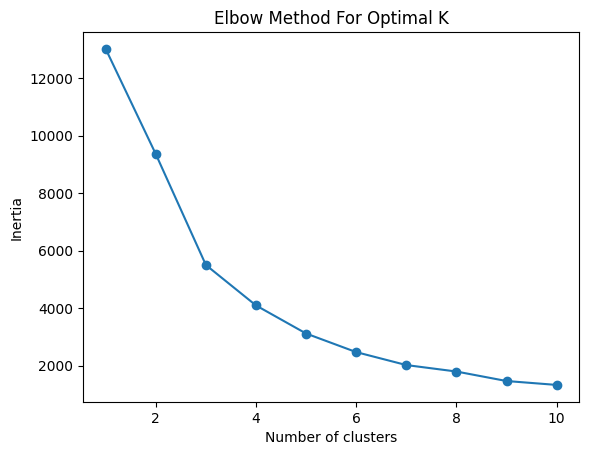

In [21]:
plt.plot(K, inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal K')
plt.show()

In [22]:
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)
rfm.head()


,CustomerID,Recency,Frequency,Monetary,Cluster
0,12346.0,326,1,77183.60,3
1,12347.0,2,7,4310.00,0
2,12348.0,75,4,1797.24,0
3,12349.0,19,1,1757.55,0
4,12350.0,310,1,334.40,1


In [23]:
score = silhouette_score(rfm_scaled, rfm['Cluster'])
print("Silhouette Score:", score)


Silhouette Score: 0.6162275299061803


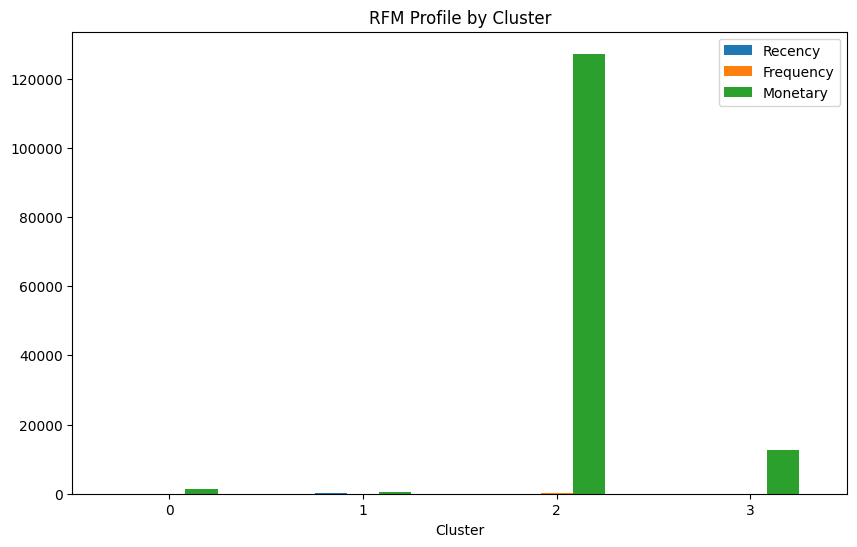

In [24]:
rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean().plot(kind='bar', figsize=(10, 6))
plt.title("RFM Profile by Cluster")
plt.xticks(rotation=0)
plt.show()


In [25]:
basket = df.pivot_table(index='CustomerID', columns='StockCode', values='Quantity', aggfunc='sum', fill_value=0)


In [26]:
similarity_matrix = cosine_similarity(basket.T)
similarity_df = pd.DataFrame(similarity_matrix, index=basket.columns, columns=basket.columns)


In [27]:
def recommend_products(product_code, top_n=5):
    if product_code not in similarity_df:
        return []
    similar_scores = similarity_df[product_code].sort_values(ascending=False)[1:top_n+1]
    return list(similar_scores.index)

# Example
recommend_products('85123A')


['21175', '21733', '82552', '82551', '23288']

In [28]:
import os
os.makedirs('../models', exist_ok=True)

joblib.dump(kmeans, '../models/kmeans_rfm_model.pkl')
joblib.dump(scaler, '../models/rfm_scaler.pkl')
similarity_df.to_pickle('../models/similarity_df.pkl')

# Optional: Save processed datasets
rfm.to_csv('../models/rfm_clusters.csv', index=False)
df.to_csv('../models/cleaned_df.csv', index=False)
